TODO:


R1
-	get the Nyquist plot axis dimensions issue when $k=1$ fixed
-	figure out the failing of .pz with active elements


R2
-	make the frequency analysis stuff happen


In [1]:
from skidl.pyspice import *
#can you say cheeky 
import PySpice as pspice
#becouse it's written by a kiwi you know
import lcapy as kiwi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sym

from scipy.signal import zpk2tf as scipy_zpk2tf


from IPython.display import YouTubeVideo, display

import traceback
import warnings

In [2]:
#import dc code from parral folder
import sys
sys.path.insert(1, '../DC_1/')
from DC_1_Codes import get_skidl_spice_ref, easy_tf

from AC_2_Codes import *

sym.init_printing()

#notebook specific loading control statements 
%matplotlib inline
#tool to log notebook internals
#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information skidl, PySpice,lcapy, sympy, numpy, matplotlib, pandas, scipy

Software,Version
Python,3.7.6 64bit [GCC 7.3.0]
IPython,7.12.0
OS,Linux 4.19.104 microsoft standard x86_64 with debian bullseye sid
skidl,0.0.31.dev0
PySpice,1.4.3
lcapy,0.75.dev0
sympy,1.6.2
numpy,1.18.1
matplotlib,3.3.0
pandas,1.1.4


# What is PZ anylsis

Pole-Zero analysis (.pz)does exactly what it says it does. It analysis the circuit between two ports and will return all the poles and or zero between the ports and that's it. That means with the resulting poles and zeros we can reconstruct the transfer function between the ports up to the gain term that is $$H(s)_{true}\propto \dfrac{\prod_n (s-a_n)}{\prod_m (s-b_m)}$$ where $a_n$ are the zeros and $b_n$ are the poles. Again this can't be stressed enough .pz does not recover the "gain" term $K$ that would turn the proportionality into an equality.

So what use is it? While that depends on what stage of the design cycle you're in and what is being analyzed. So for RLC elements, it's just going to tell us the poles and zeros where we know that the poles and zero do not move. But for active devices such as BJTs, FETs, etc we could cycle the .pz analysis and see how the .pz locations move with the bias. And while .pz is limited from a verification standpoint seeing as it will just confirm the pole-zero locations that should have been set in the design stage it can be of use when performing reverse engineering on an unknown circuit. Further during the design stage or when analyzing an unknown circuit the lack of $K$ is not a total handicap. Since even without $K$ we can perform root-locus analysis or we can sweep $K$ while comparing the resulting transfer function response to an .ac simulation to then determine $K$ when reverse engineering an unknown design.

So then let's go ahead and start looking at .pz and what we can do with that data.


# PZ analysis of an RC lowpass filter

For this first use case, we will use the RC lowpass filter that we developed in the last section bassed on the work of ALL ABOUT ELECTRONICS

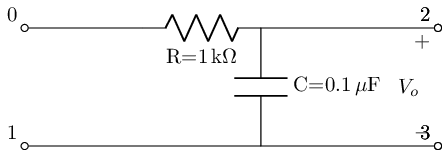

In [3]:
#instatate the rc_lowpass filter to 
lowpassF=rc_lowpass(C_value=.1@u_uF, R_value=1@u_kOhm)
lowpassF.lcapy_self()

Lets then get the voltage transfer function for this filter topology

In [4]:
H_rcl_gen=lowpassF.get_tf(with_values=False); H_rcl_gen

      1      
─────────────
    ⎛     1 ⎞
C⋅R⋅⎜s + ───⎟
    ⎝    C⋅R⎠

The voltage transfer function for this topology shows that it has a single pole and the following gain term $K$

In [5]:
H_rcl_gen.K

 1 
───
C⋅R

Real quickly how lcapy is getting the full voltage-transfer function is based on

1.	Generating the symbolic Modified nodal analysis in the Laplace domain

2.	extracting the so-called Two-Port admittance parameters $Y$ from the Modified nodal analysis matrix

3.	finding the port 1 to port 2 voltage transfer function via $$H_v(s)=\dfrac{Y_{21}}{Y_{22}}$$ Which is just one way of doing it. Where more on two-port network theory and SPICE acquisition will be shown in the remaining sections of this chapter.

Lets now get the transfer function for this instinacs of the rc lowpass topology and isolate its $K$ term


In [6]:
H_rcl=lowpassF.get_tf(with_values=True, ZPK=True); H_rcl

  10000  
─────────
s + 10000

In [7]:
#K should always be real or where in trouble
K_rcl=np.real(H_rcl.K.cval); K_rcl

As with any SPICE simulation we have to instantiate our DUT in a circuit. However unlike DC's .tf we do not actually have to have any supplies but since we are also going be comparing the .ac simulation to what .pz we need a full circuit with a source to perform the .ac simulation

In [8]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out'); 

#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V, dc_offset=5@u_V); vs['p', 'n']+=net_in, gnd

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
lowpassF.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)


.title 
V1 In 0 DC 5V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
C1 Out 0 0.1uF
R1 In Out 1kOhm




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


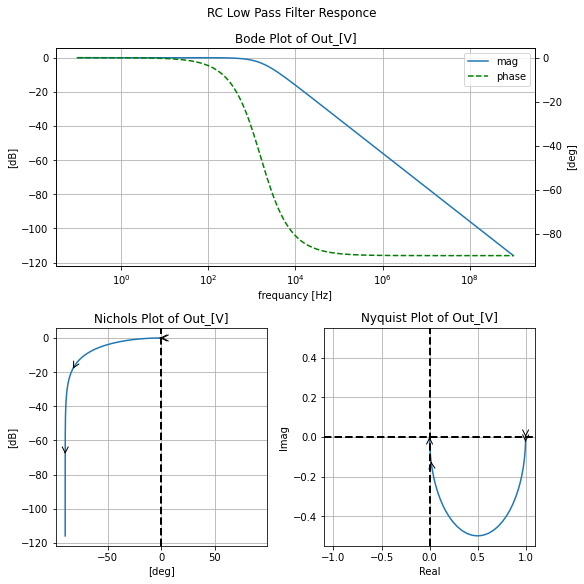

In [9]:
filter_responce=qfilter_explorer(circ, 'RC Low Pass Filter Responce');

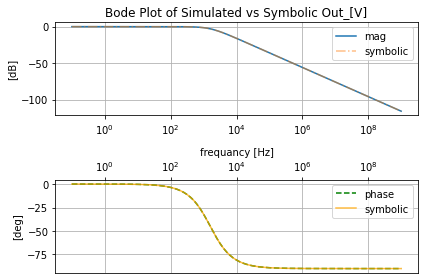

In [10]:
#this is the full filter tf response in comparison to the .ac sim
filter_responce.symbolic_tf(lowpassF)

## .tf does not get $K$

Lets be clear about this .tf will not yield $K$ in the generic case. It might get lucky but recalling that in DC simulations capcitors are treated as non existing elements there is no way that .tf will recover the $K$ for this topology where $K=\dfrac{1}{RC}$


In [11]:
tf=easy_tf(circ)

In [12]:
tf.dc_voltage_gain(vs, node(net_out), node(gnd))
tf.vg_results

,loc,value,units
Output_resistance,(Out-0),1000,[Ohm]
Input_resistance,V1,1e+20,[Ohm]
DC_Vgain,(Out-0)/V1,1,[V/V]


# PZ ease

The following class like the rest in this book makes using the SPICE analysis easier and enhance it with the power of Python. But real quick let's look at the ngspice call for .pz (typically found in chapter 15 section 3)

```
.pz node1 node2 node3 node4 <transfer_type('vol'/'cur')> <analysis_type('pz'/'zer'/'pol')>
```

This differs from .tf in DC analysis where we had to specify a source for the input, where instead the input port terminals are specified by `node1` & `node2` which are the positive and negative terminals respectively. And similarly, the output port terminals are specified by `node3` & `node4`. Since .pz only requires the specification of the terminals to define the two-port network we can take advantage of this to look just at sat the feedback (aka $\beta$) network in circuits containing feedback structures.

Following the node arguments are the transfer type argument where if `vol` is used we are acquiring the poles and or zeros of voltage transfer function 

$$H_v(s)=\dfrac{V_o}{V_i}$$

else, if `cur` is used we are acquiring the Transimpedance (aka Transfer Impedance) 
$$H_F(s)=\dfrac{V_o}{I_i}$$
, were again when using .pz we are only acquiring the poles and or zeros that make up the respective transfer function not the transfer function as a whole.

Finlay the last argument `analysis_type` controls what we are acquiring from the .pz analysis. While typically we leave it as `pz` to get both the poles and zeros there are times it might not be possible to get both or the poles and zero have to be acquired separately. Where in that case we can use `pol` to get just the poles and `zer` to get just the zeros

Below the class, `pz_ease` is designed to perform the .pz analysis with additional methods to analyze the results. And in both it's instantiation and in serval of its methods, the value of $K$ can be feed into it if known.


In [13]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section 4 pz_ease class
#class to perform .pz simulations with a bit more grace 
#with some additional built-in analysis tools

class pz_ease(ac_representation_tool, eecomplex_plot_templets):
    def __init__(self, circ_netlist_obj, K=1.0):
        """
        Class to perform Pole Zero (.pz) SPICE simulation with grace
        
        Args:
            circ_netlist_obj (pyspice.Spice.Netlist.Circuit): the Netlist circuit produced 
                from SKiDl's `generate_netlist()`
            
            K (float/int; 1): the gain; must be manually put in or found from .tf analysis
        
        Returns: 
            
        """
        self.circ_netlist_obj=circ_netlist_obj
        
        assert (type(K)==float) or (type(K)==int), 'K must be a float or int'
        self.K=K
        
        
        #dic of allowed pz control statements
        self.allowed_control_statments={'voltage':'vol', 'current':'cur',
                                       'pole-zero':'pz', 'zeros':'zer', 'poles':'pol'}

    
    def pz_def_ports(self, port_0_pos_term, port_0_neg_term, port_1_pos_term, port_1_neg_term, display_table=False):
        """
        Method to set the Port terminals for the two-port section of the circuit under test
        where all inputs must be nodes in the circuit under test
        
        Terminals:
        port_0_pos_term, port_0_neg_term, port_1_pos_term, port_1_neg_term
        
        Port & Terminals are defined via:
        ```
                        Left_Port - Two-Port Section under Test - Right_Port
                                        +-------------+  
        Postive Port0   port_0_pos_term-| DUT Section |-port_1_pos_term     Postive Port1
        Negtive Port0   port_0_neg_term-|             |-port_1_neg_term     Negtive Port1
                                        +-------------+
        ```
        Args:
            display_table (bool; False): when true will display the generated `self.control_df` below
                this method call in a jupyter notebook like environment
            
        
        Returns:
            Settings are recoded in `self.control_df` rows: `'port_0_terms+-'` & `'port_1_terms+-'`
        """
        
        assert port_0_pos_term in self.circ_netlist_obj.node_names, f'`{port_0_pos_term}` is not a node in the circuit under test'
        self.port_0_pos_term=port_0_pos_term
        
        assert port_0_neg_term in self.circ_netlist_obj.node_names, f'`{port_0_neg_term}` is not a node in the circuit under test'
        self.port_0_neg_term=port_0_neg_term
        
        assert port_1_pos_term in self.circ_netlist_obj.node_names, f'`{port_1_pos_term}` is not a node in the circuit under test'
        self.port_1_pos_term=port_1_pos_term
        
        assert port_1_neg_term in self.circ_netlist_obj.node_names, f'`{port_1_neg_term}` is not a node in the circuit under test'
        self.port_1_neg_term=port_1_neg_term
        
        #record the results in table
        self._build_control_table(display_table)
        
    
    def pz_mode_set(self, tf_type='voltage', pz_acu='pole-zero', display_table=False):
        """
        Method to set the pole-zero analysis controls
        
        Args:
            tf_type (str; 'voltage'): the tf for wich the poles and zeros fit to
                if `voltage` the tf is of the form V_o/V_i else if `current` in the form of
                V_o/I_i
            
            pz_acu (str; 'pole-zero'): if `pole-zero` will attempt to get all the poles and zeros for the
                specfied transfer function; else if `zeros` or `poles` will get just the respective zeros
                or poles 
            
            display_table (bool; False): when true will display the generated `self.control_df` below
                this method call in a jupyter notebook like environment
        
        Returns:
            Settings are recoded in `self.control_df` rows: `'tf_type'` & `'acqui_mode'`
        
        
        """
        assert tf_type in self.allowed_control_statments.keys(), f'`{tf_type}` is not `voltage` or `current`'
        self.tf_type=tf_type
        
        assert pz_acu in self.allowed_control_statments.keys(), f'`{pz_acu}` is not `pole-zero` or `poles` or `zeros`'
        self.pz_acu=pz_acu
        
        #record the results in table
        self._build_control_table(display_table)
        
    def _build_control_table(self, display_table=True):
        """
        Internal method to build a pz control table to display pz simulation settings
        
        Args:
            display_table (bool; True): when true will display the generated `self.control_df` below
                this method call in a jupyter notebook like environment
        
        Returns:
            creates dataframe table `self.control_df` that records pz simulation controls
            if `display_table` is true will force showing under jupyter notebook cell
            
        """
        
        self.control_df=pd.DataFrame(columns=['value'], 
                                     index=['tf_type', 
                                            'acqui_mode',
                                            'port_0_terms+-',
                                            'port_1_terms+-'
                                           ])
        if hasattr(self, 'tf_type'):
            self.control_df.at['tf_type']=self.tf_type
        
        if hasattr(self, 'pz_acu'):
            self.control_df.at['acqui_mode']=self.pz_acu
        
        if hasattr(self, 'port_0_pos_term') and hasattr(self, 'port_0_neg_term') :
            self.control_df.at['port_0_terms+-', 'value']=[self.port_0_pos_term,  self.port_0_neg_term]
        
        if hasattr(self, 'port_1_pos_term') and hasattr(self, 'port_1_neg_term') :
            self.control_df.at['port_1_terms+-', 'value']=[self.port_1_pos_term,  self.port_1_neg_term]
        
        self.control_df.index.name='pz_sim_control'
        
        if display_table:
            display(self.control_df)
        
    
    def do_pz_sim(self, display_table=False):
        """
        Method to perform the pole-zero simulation based on values stored in self.control_df
        If the simulation does not converge will give a warning with a basic debug action
        but will set `self.pz_values` to empty dict.
        
        TODO:
            - add simulation kwargs
            - flush out exception handling
        """
        
        attriputs_to_check=['port_0_pos_term', 'port_0_neg_term', 'port_1_pos_term', 'port_1_neg_term', 
                           'tf_type', 'pz_acu']
        
        for i in attriputs_to_check:
            if hasattr(self, i):
                pz_is_go=True
            else:
                pz_is_go=False
                warnings.warn(f'{i} has not been set; pole-zero simulation will not procdede till set')
                
        if pz_is_go:
            self.sim=self.circ_netlist_obj.simulator()
            #I cant catch the warning when it hangs so going to have to do this
            self.pz_values={}

            try:
                self.pz_values=self.sim.polezero(
                    node1=self.port_0_pos_term, 
                    node2=self.port_0_neg_term, 
                    node3=self.port_1_pos_term, 
                    node4=self.port_1_neg_term, 
                    tf_type=self.allowed_control_statments[self.tf_type], 
                    pz_type=self.allowed_control_statments[self.pz_acu]
                )
                
                self._record_pz_results(display_table)
            
            except pspice.Spice.NgSpice.Shared.NgSpiceCommandError:
                self.pz_values={}
                warnings.warn("""PZ analysis did not converge with the current setting:
                start by changing the tf type (self.tf_type) and pz acusisiton type (self.pz_acu) """)
            
    
    def _record_pz_results(self, display_table=True):
        """
        Internal method to record the PZ results to a dataframe
        
        Args:
            display_table (bool; True): when true will display the generated `self.control_df` below
                this method call in a jupyter notebook like environment
        
        Returns:
            creates dataframe table `self.pz_results_DF` that records pz simulation results
            if `display_table` is true will force showing under jupyter notebook cell
            
        """
        self.pz_results_DF=pd.DataFrame(columns=['Type', 'Values'])
        
        if hasattr(self.pz_values, 'nodes'):
            for k, v in self.pz_values.nodes.items():
                self.pz_results_DF.at[len(self.pz_results_DF)]=k, v.as_ndarray()[0]
        
        if display_table:
            display(self.pz_results_DF)
            
        
    def get_pz_sym_tf(self, dec_round=None, overload_K=None):
        """
        Method to get the symbolic transfer function via lacpy
        
        Args:
            dec_round (int; None): contorl to `np.around`'s `decimals` argument
                if left `None` np.around will not be used
            
            overload_K (float/int; None): if not `None` will overload the DC
                gain constant stored in `self.K`
        
        Returns:
            if `self.pz_results_DF` exists return the symbolic transfer function in the s
            dominan in `self.sym_tf`
        """
        if overload_K!=None:
            assert (type(overload_K)==float) or (type(overload_K)==int), 'K must be a float or int'
            self.K=overload_K
        
        if hasattr(self, 'pz_results_DF')!=True:
            warnings.warn('no poles/zero recorded run `self.do_pz_sim`')
        else:
            zeros_B=np.empty(0)
            poles_A=np.empty(0)
            for index, row in self.pz_results_DF.iterrows():
                if 'zero' in row['Type']:
                    zeros_B=np.hstack((zeros_B, row['Values']))
                elif 'pole' in row['Type']:
                    poles_A=np.hstack((poles_A, row['Values']))
            
            if dec_round!=None:
                zeros_B=np.around(zeros_B, dec_round)
                poles_A=np.around(poles_A, dec_round)
            
            self.zeros_B=zeros_B; self.poles_A=poles_A
            #wish I didn't have to do this
            zeros_B=zeros_B.tolist(); poles_A=poles_A.tolist()  
            
            #use lcapy to get the symbolic tf 
            self.sym_tf=kiwi.zp2tf(zeros_B, poles_A, K=self.K)
            #use simplify because if in pzk it does weird things with j that
            #lambdfy has issues with
            self.sym_tf=self.sym_tf.simplify()
            
    def plot_pz_loc(self, ax=None, title='', unitcircle=False):
        """
        uses lcapy's `plot_pole_zero` in https://github.com/mph-/lcapy/blob/6e42983d6b77954e694057d61045bd73d17b4616/lcapy/plot.py#L12
        to plot the poles and zero locations on a Nyquist chart
        
        Args:
            axs (list of matplotlib axis; None): If left None will create a new plot, else must 
                be a list of matplotlib subplots axis to be added to where the first entry
                will be the magnitude axis, and the second will be the phase axis
            
            title (str; ''): Subplot title string
            
            unitcircle (bool; False): when True will plot the unit circle on the resulting plot
        
        Returns:
            Returns a real-imag with Poles and Zero map, and if an axis was passed to `ax` will be modified
            with the pole-zero map
        
        
        """
        axs=ax or plt.gca()
        if hasattr(self, 'sym_tf')==False:
            warnings.warn("""Trying to get symbolic transfer function from `self.get_pz_sym_tf`
            thus you will get what you get""")
            self.get_pz_sym_tf()
        
        self.sym_tf.plot(axes=axs, unitcircle=unitcircle, 
                         #wish there be a better way to do this
                        label="'X'=pole; 'O'=zero")
        
        axs.axhline(0, linestyle='--', linewidth=2.0, color='black')
        axs.axvline(0, linestyle='--', linewidth=2.0, color='black')
        axs.set_xlabel('Real'); axs.set_ylabel('Imag')
        
        axs.legend()
        
        if title!='':
            title=' of '+title
        axs.set_title(f'Pole-Zero locations plot{title}');

    
    
    def plot_3d_laplce(self, title=''):
        """
        Creates 3d plots of the Laplace space of the transfer function, one for the mag
        the other for the phase in degrees unwrapped
        
        Args:
                title (str; ''): Subplot title string
        
        Returns:
            returns a 3d plot with the left subplot being the  mag and the right being the phase
        
        TODO:
            - get the freaking color bar into a clean location when working with 3d plots
            - merge phase as color into mag see the physics video by eugene on Laplace 
        """
        if hasattr(self, 'sym_tf')==False:
            warnings.warn("""Trying to get symbolic transfer function from `self.get_pz_sym_tf`
            thus you will get what you get""")
            self.get_pz_sym_tf()
        
        #import the additnal matplotlib featuers for 3d
        from mpl_toolkits.mplot3d import Axes3D
        from matplotlib import cm
        
        #stole this off lcapy's plot_pole_zero
        #https://github.com/mph-/lcapy/blob/7c4225f2159aa33398dac481041ed538169b7058/lcapy/plot.py
        
        
        #check self.sys_tf is good to be used
        sys_tf_syms=self.sym_tf.symbols
        assert len(sys_tf_syms)==1 and ('s' in sys_tf_syms.keys()), 'trasfer function must be laplce form and only have `s` as a free symbol'

        #lambdfy the tf
        sys_tf_lam=sym.lambdify(kiwi.s, self.sym_tf.canonical(), 'numpy', dummify=False)

        #get the plot bounds
        #stole this off lcapy's plot_pole_zero
        #https://github.com/mph-/lcapy/blob/7c4225f2159aa33398dac481041ed538169b7058/lcapy/plot.py

        poles = self.sym_tf.poles()
        zeros = self.sym_tf.zeros()
        try:
            p = np.array([p.cval for p in poles.keys()])
            z = np.array([z.cval for z in zeros.keys()])
        except ValueError:
            raise TypeError('Cannot get poles and zeros of `self.sym_tf')
        a = np.hstack((p, z))
        x_min = a.real.min()
        x_max = a.real.max()
        y_min = a.imag.min()
        y_max = a.imag.max()

        x_extra, y_extra = 3.0, 3.0

        # This needs tweaking for better bounds.
        if len(a) >= 2:
            x_extra, y_extra = 0.1 * (x_max - x_min), 0.1 * (y_max - y_min)
        if x_extra == 0:
            x_extra += 1.0
        if y_extra == 0:
            y_extra += 1.0

        x_min -= 0.5 * x_extra
        x_max += 0.5 * x_extra
        y_min -= 0.5 * y_extra
        y_max += 0.5 * y_extra

        #the input domain
        RealRange=np.linspace(x_min, x_max, 100); ImagRange=np.linspace(y_min, y_max, 100)
        sr, si=np.meshgrid(RealRange, ImagRange)
        s_num=sr+1j*si

        #plot this
        fig = plt.figure()
        
        #mag 3d plot
        ax3d_mag = fig.add_subplot(121, projection='3d')

        XmagPlot=ax3d_mag.plot_surface(sr, si, np.abs(sys_tf_lam(s_num)), alpha=0.5,
                                 cmap=cm.coolwarm, antialiased=False)
        ax3d_mag.set_xlabel(r'$\sigma$'); ax3d_mag.set_ylabel(r'$j\omega$'), ax3d_mag.set_zlabel(r'$|X|$')
        fig.colorbar(XmagPlot, shrink=0.5, aspect=5)

        #phase 3d plot
        ax3d_phase = fig.add_subplot(122, projection='3d')

        XphasePlot=ax3d_phase.plot_surface(sr, si, angle_phase_unwrap(sys_tf_lam(s_num)), alpha=0.5,
                                 cmap=cm.coolwarm, antialiased=False)
        ax3d_phase.set_xlabel(r'$\sigma$'); ax3d_phase.set_ylabel(r'$j\omega$'), ax3d_phase.set_zlabel(r'$ang(X)$')
        fig.colorbar(XphasePlot, shrink=0.5, aspect=5)

        plt.tight_layout()
        
        if title!='':
            title=' of '+title
        ax3d_mag.set_title(f'3D Mag Laplace plot{title}');
        ax3d_phase.set_title(f'3D Phase_deg Laplace plot{title}');

    
    
    def scipy_pzk(self, dec_round=None, overload_K=None):
        """
        Method to create to generate the Numerator (a) and Denominator (b)
        arrays to use within the scipy signal framework see 
        https://docs.scipy.org/doc/scipy/reference/signal.html
        &
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.zpk2tf.html#scipy.signal.zpk2tf
        
        Args:
            dec_round (int; None): contorl to `np.around`'s `decimals` argument
                if left `None` np.around will not be used
            
            overload_K (float/int; None): if not `None` will overload the DC
                gain constant stored in `self.K`
        
        Returns:
            if `self.pz_results_DF` exists tries to return the coefficients for an lti
            filter for use in scipy's signal library in a dictionary in `self.scipy_tfcoef`
        """
        if overload_K!=None:
            assert (type(overload_K)==float) or (type(overload_K)==int), 'K must be a float or int'
            self.K=overload_K
        
        if hasattr(self, 'pz_results_DF')!=True:
            warnings.warn('no poles/zero recorded run `self.do_pz_sim`')
        else:
            zeros_B=np.empty(0)
            poles_A=np.empty(0)
            for index, row in self.pz_results_DF.iterrows():
                if 'zero' in row['Type']:
                    zeros_B=np.hstack((zeros_B, row['Values']))
                elif 'pole' in row['Type']:
                    poles_A=np.hstack((poles_A, row['Values']))
            
            if dec_round!=None:
                zeros_B=np.around(zeros_B, dec_round)
                poles_A=np.around(poles_A, dec_round)
                
            b, a=scipy_zpk2tf(zeros_B, poles_A, self.K)
            self.scipy_tfcoef={'b':b, 'a':a}
    
    def get_sym_freq_resp(self, freq_vec=None):
        """
        method to get the symbolic transfer function  response 
        
        Args:
            freq_vec (numpy array or pandas series; None): frequencies
            to generate results from the generated symbolic transfer function
            if `None` will come up with a freancy vector inside via `np.logspace(-1, 12, 12*10*10)`
        
        Returns:
            will store frequency vector as the index in `self.pz_symresults_DF`
            where the response of the symbolic transfer function will be stored
            in `self.pz_symresults_DF['pzk_symres_[V]']` from there will
            use the inheritance from `ac_representation_tool` to then 
            generate `self.ac_sim_real_DF['pzk_symres_[V]'], self.ac_sim_imag_DF['pzk_symres_[V]']`, ect
            
        """
        if hasattr(self, 'sym_tf')==False:
            warnings.warn("""Trying to get symbolic transfer function from `self.get_pz_sym_tf`
            thus you will get what you get""")
            self.get_pz_sym_tf()
            
        if freq_vec==None:
            self.freq_vec=np.logspace(-1, 12, 12*10*10)
        
        self.pz_symresults_DF=pd.DataFrame(index=self.freq_vec)
        self.pz_symresults_DF.index.name='freq[Hz]'
        
        self.pz_symresults_DF['pzk_symres_[V]']=self.sym_tf.frequency_response(self.pz_symresults_DF.index.values).astype('complex')
        
        ac_representation_tool.__init__(self, self.pz_symresults_DF)
        
        #just make the reps
        self.make_real_imag()
        self.make_mag_phase()
    
    def plot_nyquist_with_pz(self, ax=None, title='', unitcircle=False):
        """
        plotting utility to plot the pole-zero location on top of a Nyquist
        a plot of the response of the symbolic transfer function
        
        Args:
            ax (matplotlib axis; None): If left None will create a new plot, else must
                be a matplotlib subplot axis to be added to
            
            title (str; ''): Subplot title string
            
        Returns:
            Returns a Nyquist plot with the pole-zero locations superimposed on top of, 
            and if an axis was passed to `ax` will be modified
            
            
        
        """
        axs=ax or plt.gca()
        if hasattr(self, 'ac_sim_real_DF')==False:
            warnings.warn("""Trying to get the real imag data from `self.get_sym_freq_resp`, 
            you get what you get""")
            self.get_sym_freq_resp()
        
        
        self.nyquist_plot_templet(self.ac_sim_real_DF['pzk_symres_[V]'], self.ac_sim_imag_DF['pzk_symres_[V]'], 
                           ax=axs)
        self.plot_pz_loc(ax=axs, unitcircle=unitcircle)

        
        if title!='':
            title=' of '+title
        axs.set_title(f'Nyquist with Pole-Zero locations plot{title}');
    
    def plot_bode_from_pz(self, ax=None, title=''):
        """
        plotting utility to plot single mag and phase on a single bode plot 
        for the response of the symbolic transfer function
        
        Args:
            ax (matplotlib axis; None): If left None will create a new plot, else must
                be a matplotlib subplot axis to be added to
            
            title (str; ''): Subplot title string
            
        Returns:
            Returns a bode plot from the symbolic transfer function, 
            and if an axis was passed to `ax` will be modified
        """
        axs=ax or plt.gca()
        if hasattr(self, 'ac_sim_real_DF')==False:
            warnings.warn("""Trying to get the mag phase data from `self.get_sym_freq_resp`, 
            you get what you get""")
            self.get_sym_freq_resp()
        
        
        
        self.bode_plot_one_templet(self.ac_sim_mag_DF.index, self.ac_sim_mag_DF['pzk_symres_[V][dB]'], self.ac_sim_phase_DF['pzk_symres_[V][deg]'], 
                           ax=axs)
        
        if title!='':
            title=' of '+title
        axs.set_title(f'Bode plot from Pole-Zero anylsis plot{title}');
    
    def plot_nichols_from_pz(self, ax=None, title=''):
        """
        plotting utility to plot the Nichols chart
        for the response of the symbolic transfer function
        
        Args:
            ax (matplotlib axis; None): If left None will create a new plot, else must
                be a matplotlib subplot axis to be added to
            
            title (str; ''): Subplot title string
            
        Returns:
            Returns a Nichols chart plot from the symbolic transfer function, 
            and if an axis was passed to `ax` will be modified
        """
        axs=ax or plt.gca()
        
        if hasattr(self, 'ac_sim_real_DF')==False:
            warnings.warn("""Trying to get the mag phase data from `self.get_sym_freq_resp`, 
            you get what you get""")
            self.get_sym_freq_resp()
        
        
        
        self.nichols_plot_templet(self.ac_sim_mag_DF['pzk_symres_[V][dB]'], self.ac_sim_phase_DF['pzk_symres_[V][deg]'], 
                           ax=axs)
        
        if title!='':
            title=' of '+title
        axs.set_title(f'Nichols plot from Pole-Zero anylsis plot{title}');
    

To use `pz_ease` we instantiate it by passing in the circuit under test at the time of creation. The instantiation has another argument to pass in $K$ if known *a prior* if just the moment we will leave $K=1$ to demonstrate what .pz and `pz_ease` can do when $K$ is not known

In [14]:
pz=pz_ease(circ)

next, we define the port terminals and set the control for the voltage transfer function and to get both poles and zero which is the default case.

In [15]:
pz.pz_def_ports('In', '0', 'Out', '0')
pz.pz_mode_set( display_table=True)

,value
pz_sim_control,
tf_type,voltage
acqui_mode,pole-zero
port_0_terms+-,"[In, 0]"
port_1_terms+-,"[Out, 0]"


And so now we run the .pz simulation

In [16]:
pz.do_pz_sim(display_table=True)

,Type,Values
0,pole(1),(-10000+0j)


## Results when $K=1$

And we see that we get the pole that we know exists with the value we expect. So now then we can feed the results into Lcapy's zp2tf to generate the symbolic transfer function. Where we will keep $K=1$ for the moment

In [17]:
pz.get_pz_sym_tf()
H_pzk1=pz.sym_tf; H_pzk1

     1     
───────────
s + 10000.0

We can now plot the pole zero locations

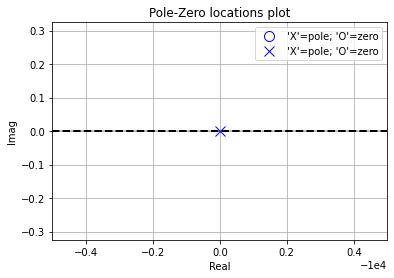

In [18]:
pz.plot_pz_loc()

Generate the 3d plot of the Laplace domain response of this filter. Where the Laplace variable $s$ is equal to 
$$s=\sigma +j\omega$$
where $j\omega$ is the angular frequency response and when $\sigma$ is zero $s$ gives yields the Fourier transform response of the system. Otherwise $\sigma=1/\tau$ the decay response of the system. For more info review the section ["Transfer Function Analysis"](https://control.com/textbook/ac-electricity/transfer-function-analysis/) from the controls book at https://control.com/

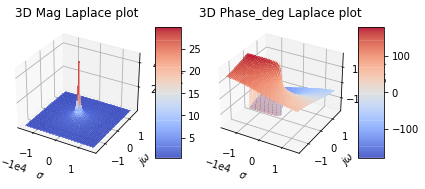

In [19]:
pz.plot_3d_laplce()

We then can get the symbolic transfer function’s frequency response and view the Nyquist interpretation over the poles and zeros. Though when $K=1$ this can have issues in the plotting.

In [20]:
#pz.plot_nyquist_with_pz()
#dont get why this is not working with K=1

As well as plotting the symbolic transfer function’s Bode and Nichols plot interpretation of its response.

/home/iridium/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:522: UserWarning: Trying to get the mag phase data from `self.get_sym_freq_resp`, 
            you get what you get


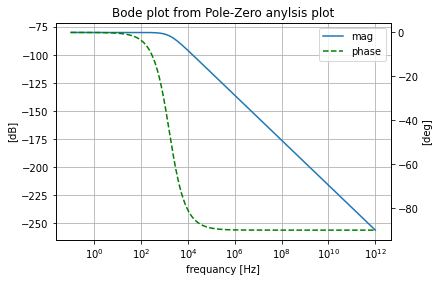

In [21]:
pz.plot_bode_from_pz()

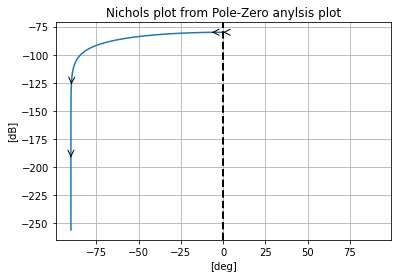

In [22]:
pz.plot_nichols_from_pz()

And finally, besides generating the symbolic transfer function, pz_ease can also use scipy's signal module to generate a dictionary containing the transfer functions numerator and denominator terms from the pole zeros and $K$ to the use within the scipy signal module or in the python controls library.

In [23]:
pz.scipy_pzk(); pz.scipy_tfcoef

{'b': array([1.]), 'a': array([1.e+00, 1.e+04])}

## Results with Proper $K$

Now giggle and grin lets see what our lowpass filtes full transfer function responce looks like when we know $K$ using the SPICE estracted poles and zeros from .pz anylsis. Where after overriding the $K$ in `pz_ease` we need to rerun `pz_ease.get_sym_freq_resp()` to regenerate the symploic transfer functions respnonce for the new sympolic transfer function found after $K$ what overridden

In [24]:
pz.get_pz_sym_tf(overload_K=K_rcl)
pz.get_sym_freq_resp()
H_pzk1=pz.sym_tf; H_pzk1

   10000   
───────────
s + 10000.0

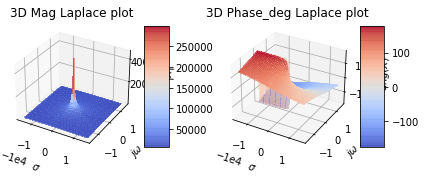

In [25]:
pz.plot_3d_laplce()

In [26]:
# figure out this strange matplotlib value error
#pz.plot_nyquist_with_pz()

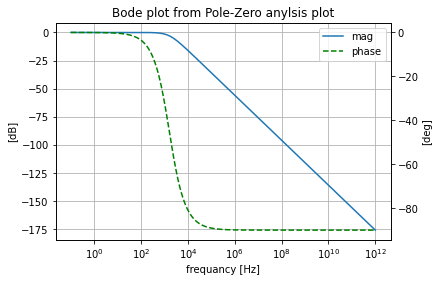

In [27]:
pz.plot_bode_from_pz()

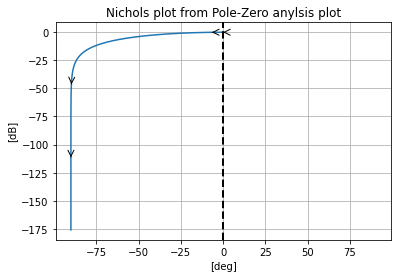

In [28]:
pz.plot_nichols_from_pz()

The results show that with an appropriate value of $K$ set we get the value that matches the .ac simulation results.

## Asking too much from .pz

Lets now see what happens when .pz does not work

In [29]:
pz.pz_mode_set(pz_acu='zeros', display_table=True)
pz.do_pz_sim(display_table=True)

,value
pz_sim_control,
tf_type,voltage
acqui_mode,zeros
port_0_terms+-,"[In, 0]"
port_1_terms+-,"[Out, 0]"


Error: There are no vectors currently active.


/home/iridium/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: PZ analysis did not converge with the current setting:
                start by changing the tf type (self.tf_type) and pz acusisiton type (self.pz_acu) 


In this first error case, the pyspice ngspice wrapper catches the ngspice error that in this case, we know is due from trying to calculate zeros from a circuit we know does not have any zeros. We can also run into cases where instead of throwing a blatant error ngspice will throw a warning when it cant converge to a solution. In which case at the moment `pz_ease` won't display the warning but will set `pz_ease.pz_values` to an empty dictionary.

# Pole-Zero analysis of a Series Band Reject filter 

Here we get the pole-zero analysis results of one of the filter examples from the previous section where we know that the transfer function has a zero coefficient term in its numerator to demonstrate the utility of `pz_ease` to formulate the transfer function form the .pz results.


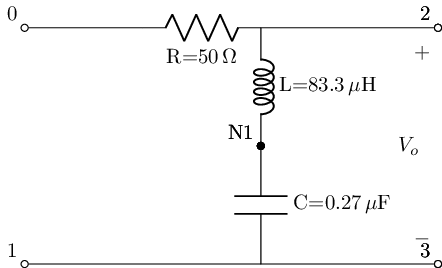

In [30]:
#instantiate the rlc_bandstop filter
bandstopRLC_s=rlc_series_bandstop(L_value=8.33e-5@u_H, C_value=2.7e-7@u_F, R_value=50@u_Ohm)
bandstopRLC_s.lcapy_self()

In [31]:
H_rlcs_bs=bandstopRLC_s.get_tf(with_values=True, ZPK=False).ratfloat(); H_rlcs_bs

           2                              
          s  + 44462229336.1789           
──────────────────────────────────────────
 2                                        
s  + 600240.096038415⋅s + 44462229336.1789

In [32]:
K_rlcs_bs=np.real(H_rlcs_bs.K.cval); K_rlcs_bs

In [33]:
reset()
#create the nets
net_in=Net('In'); net_out=Net('Out'); 

#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
bandstopRLC_s.SKiDl(net_in, gnd, net_out, gnd)

circ=generate_netlist()
print(circ)

.title 
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
L1 Out N_1 8.33e-05H
C1 N_1 0 2.7e-07
R1 In Out 50Ohm




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


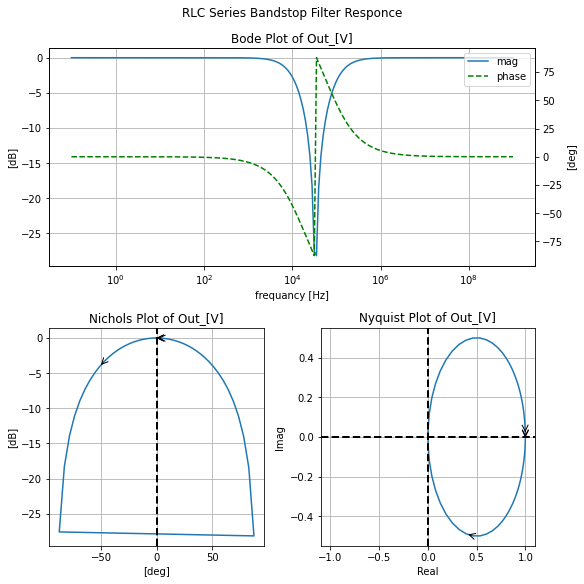

In [34]:
filter_responce=qfilter_explorer(circ, 'RLC Series Bandstop Filter Responce');

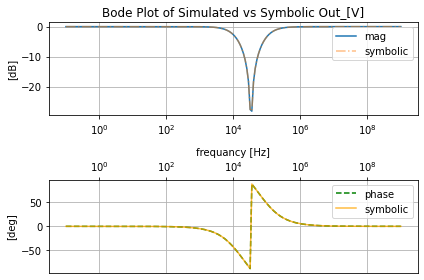

In [35]:
filter_responce.symbolic_tf(bandstopRLC_s)

Where again we will invoke the .tf of this function to show that .tf will not give us $K$ reliably only in this case serendipitously. So don't rely on it for finding $K$.

In [36]:
tf=easy_tf(circ)

In [37]:
tf.dc_voltage_gain(vs, node(net_out), node(gnd))
tf.vg_results

,loc,value,units
Output_resistance,(Out-0),50,[Ohm]
Input_resistance,V1,1e+20,[Ohm]
DC_Vgain,(Out-0)/V1,1,[V/V]


Then getting the .pz results

In [38]:
pz=pz_ease(circ, K=K_rlcs_bs)

In [39]:
pz.pz_def_ports('In', '0', 'Out', '0')
pz.pz_mode_set( display_table=True)

pz.do_pz_sim(display_table=True)

,value
pz_sim_control,
tf_type,voltage
acqui_mode,pole-zero
port_0_terms+-,"[In, 0]"
port_1_terms+-,"[Out, 0]"


,Type,Values
0,zero(2),-210860.69j
1,zero(1),210860.69j
2,pole(2),(-86555.51+0j)
3,pole(1),(-513684.6+0j)


Where the resulting transfer function the .pz anylsis is

In [40]:
pz.get_pz_sym_tf()
pz.sym_tf.canonical()

              2                            
         1.0⋅s  + 44462229532.9727         
───────────────────────────────────────────
     2                                     
1.0⋅s  + 600240.1015625⋅s + 44462230867.489

and recaling the anylsitical transfer function as the reference

In [41]:
H_rlcs_bs.ratfloat()

           2                              
          s  + 44462229336.1789           
──────────────────────────────────────────
 2                                        
s  + 600240.096038415⋅s + 44462229336.1789

We can then look at the error, wich given the size of the coefficients is small

In [42]:
#numerator error
N_error=H_rlcs_bs.N-pz.sym_tf.canonical().N
D_error=H_rlcs_bs.D-pz.sym_tf.canonical().D
print(f'Numerator Delta: {N_error}')
print(f'Denomator Delta: {D_error}')

Numerator Delta: -196.793739318848
Denomator Delta: -0.00552408467046916*s - 1531.31009674072


The so the results for scipy signal the .pz aquared pole-zeros yields

In [43]:
pz.scipy_pzk(); pz.scipy_tfcoef

{'b': array([1.00000000e+00, 0.00000000e+00, 4.44622295e+10]),
 'a': array([1.00000000e+00, 6.00240102e+05, 4.44622309e+10])}

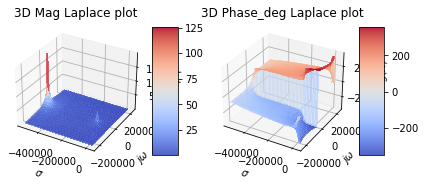

In [44]:
pz.plot_3d_laplce()

/home/iridium/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:491: UserWarning: Trying to get the real imag data from `self.get_sym_freq_resp`, 
            you get what you get


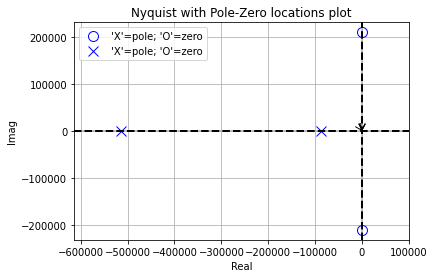

In [45]:
pz.plot_nyquist_with_pz()

Note that because of the larger space of the poles of zero for this system under test the results of the frequency response is concentrated around (0,0) and shows up as a blip.

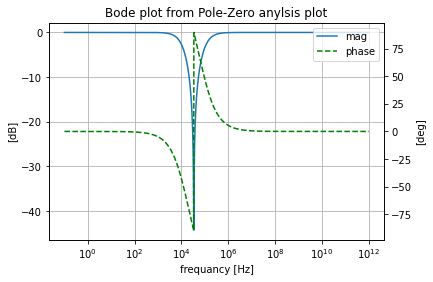

In [46]:
pz.plot_bode_from_pz()

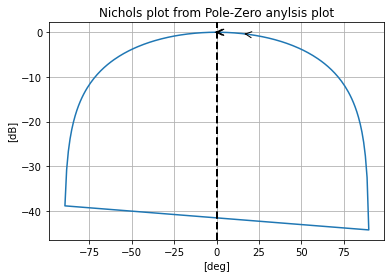

In [47]:
pz.plot_nichols_from_pz()

# Pole-Zero analysis of a lattice All-Pass filter¶

We also know that from the previous section that the lcapy generated transfer function was not correct to the .ac simulation results (properly due to this authors lcapy usage error) Thus let's take a look at what .pz gives us


Distance conflict 0.2761423749153966 vs 1.0 in horizontal graph for WWanon2 between nodes (2_2) and (2), due to incompatible sizes


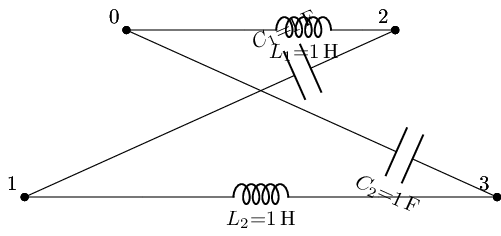

In [48]:
#instatate the all-pass lattice filter to 
allpasslat_lf=lc_balanced_allpass_lowfreq_lattice_filt()
allpasslat_lf.lcapy_self()

In [49]:
#get this filters abstract transfer function
allpasslat_lf.get_tf(with_values=True, ZPK=False)

     2
1 - s 
──────
 2    
s  + 1

In [50]:
reset()
#create the nets; the last one is needed to deal with singularity issues when dealing with lattice circuits and ground
net_in=Net('In'); net_out=Net('Out'); net_outlower=Net('Out2')
#create a 1V AC test source and attache to nets
vs=SINEV(ac_magnitude=1@u_V); vs['p', 'n']+=net_in, gnd
#net_in+=dummy_1[2]

#attaceh term_0 to net_in and term_2 to net_out per scikit-rf convention all 
#other terminals are grounded
#but need to add dummy resistors to deal with singular issues and get solvable matric
dummy_botin=R(value=0, ref='dummy')
dummy_botin[1]+=gnd

dummy_botout=R(value=0, ref='dummy')
dummy_botout[2]+=gnd
allpasslat_lf.SKiDl(net_in, dummy_botin[2], net_out, dummy_botout[1])

circ=generate_netlist()
print(circ)


.title 
V1 In 0 DC 0V AC 1V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy 0 N_1 0
Rdummy_1 N_2 0 0
L1 In Out 1H
L2 N_1 N_2 1H
C1 Out N_1 1
C2 In N_2 1




No errors or warnings found during netlist generation.



,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,1 GHz,20,decade


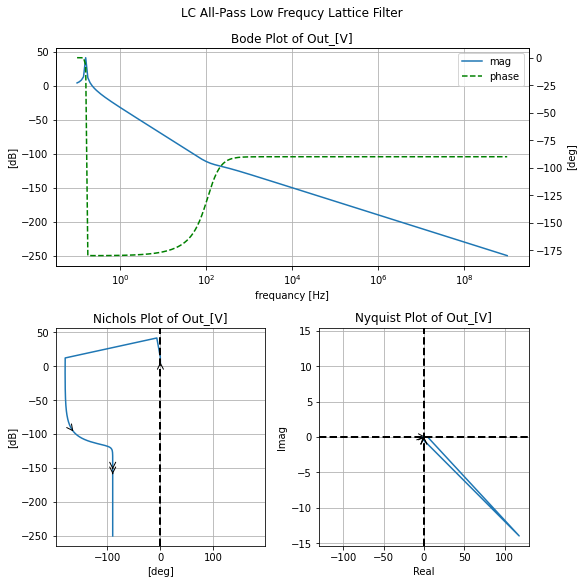

In [51]:
filter_responce=qfilter_explorer(circ, 'LC All-Pass Low Frequcy Lattice Filter');

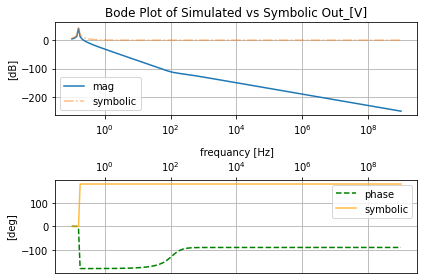

In [52]:
filter_responce.symbolic_tf(allpasslat_lf)

In [53]:
pz=pz_ease(circ, K=1)

In [54]:
pz.pz_def_ports('In', '0', 'Out', '0')
pz.pz_mode_set( display_table=True)

pz.do_pz_sim(display_table=True)

,value
pz_sim_control,
tf_type,voltage
acqui_mode,pole-zero
port_0_terms+-,"[In, 0]"
port_1_terms+-,"[Out, 0]"


,Type,Values
0,zero(3),(-0.002000004+0j)
1,zero(2),(-499.999-500j)
2,zero(1),(-499.999+500j)
3,pole(4),(-0.000499999-0.9999994j)
4,pole(3),(-0.000499999+0.9999994j)
5,pole(2),(-0.002000004+0j)
6,pole(1),(-999.999+0j)


In [55]:
pz.scipy_pzk(); pz.scipy_tfcoef

{'b': array([1.00000000e+00, 9.99999986e+02, 5.00000993e+05, 1.00000001e+03]),
 'a': array([1.00000000e+00, 1.00000202e+03, 4.00000013e+00, 1.00000208e+03,
        2.00000022e+00])}

In [56]:
pz.get_pz_sym_tf()
H=pz.sym_tf; H.canonical()

                2                                                   
           1.0⋅s  + 999.997985839844⋅s + 499998.992920936           
────────────────────────────────────────────────────────────────────
     3                     2                                        
1.0⋅s  + 1000.00002343545⋅s  + 1.99999603336759⋅s + 999.998081344856

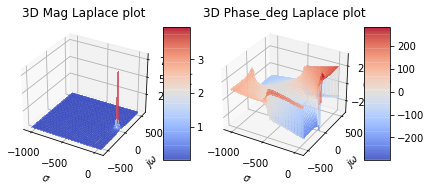

In [57]:
pz.plot_3d_laplce()

/home/iridium/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:491: UserWarning: Trying to get the real imag data from `self.get_sym_freq_resp`, 
            you get what you get


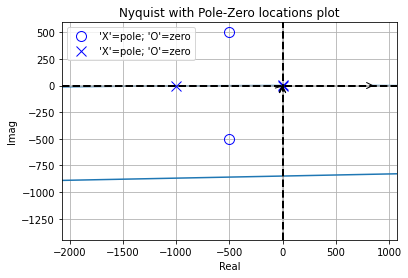

In [58]:
pz.plot_nyquist_with_pz()

Where now looking at the Bode and Nichols charts generated from the .pz analysis we see they are almost identical to what was gotten to the .ac analysis.

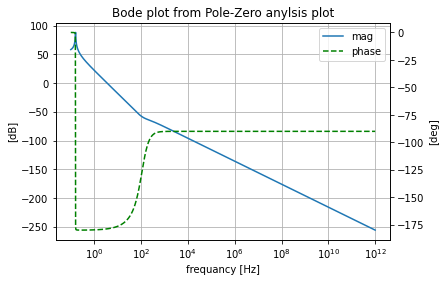

In [59]:
pz.plot_bode_from_pz()

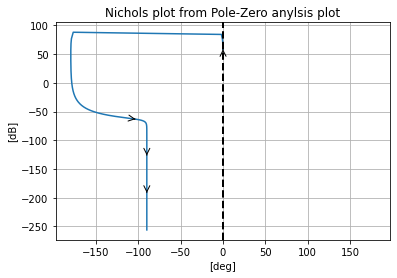

In [60]:
pz.plot_nichols_from_pz()

# Add the Razavi T-coil after the previous magnetic section is done¶

# Citations

[1] T. Kuphardt, Lessons In Industrial Instrumentation :, Version 2.30. [online], 2018, Chapter 5 Section "Transfer Function Analysis". Available: https://control.com/textbook/ac-electricity/transfer-function-analysis/. [Accessed: 10- Jan- 2021].